# Apply Channel Gating & Batch Shaping on ResNet-20 and CIFAR-10

In this project, we use the ResNets model to perform image classification on CIFAR-10. CIFAR-10 orginally contains 60K images from 10 categories. We split it into 45K/5K/10K images to serve as train/valiation/test set. We only have the ground-truth labels of training/validation dataset.

## Step 1: Set up the ResNets model

In [52]:
# import necessary dependencies
import argparse
import os, sys
import time
import datetime
from tqdm import tqdm_notebook as tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.distributions.gumbel as gm

torch.random.manual_seed(6)

### 1.1 Implement the gating module
Here is the gating module, a convolution kernel selector. We will apply this in each of the residual blocks for ResNet-20.

In [53]:
# Define the Gate module
class Gate(nn.Module):
    def __init__(self, in_channel, out_channel) -> None:
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.fc1 = nn.Linear(in_features=in_channel, out_features=16)
        self.fc2 = nn.Linear(in_features=16, out_features=out_channel)
        self.bn = nn.BatchNorm1d(num_features=16)

    def forward(self, x):
        x = self.avg_pool(x)
        x = torch.squeeze(x)
        x = self.fc1(x)
        x = self.bn(x)
        x = F.relu(x)
        x = self.fc2(x)

        # apply i.i.d. Gumbel samples
        # TRUE Gumbel: Turn logits into binary vector
        pi = torch.exp(x) # hat{pi} = ln(pi), hat{pi} is output of fc2
        x = F.gumbel_softmax(pi, tau=2/3, hard=True) 

        return x

### 1.2 Setup ResNet model

The ResNet-20 model is built hierarchically, and the gating modules are applied to residual blocks.

In [54]:
# define the ResNets mode;
class BasicBlock(nn.Module):
    expansion = 4
    def __init__(self,input1,output,kernel,s,downsample=None):
        super(BasicBlock,self).__init__()
        self.conv1 = nn.Conv2d(input1,output,kernel,stride =s ,padding = 1)
        self.conv1bn = nn.BatchNorm2d(output)
        self.conv2 = nn.Conv2d(output,output,kernel,stride =1 ,padding = 1)
        self.conv2bn = nn.BatchNorm2d(output)
        self.shortcut = nn.Sequential()
        self.out_filter = output
        self.stride = s
        self.downsample = downsample

        # Channel gating module
        self.gate = Gate(input1, output)
    def forward(self,x):
        # Process selection information from the inputs
        gate_out = self.gate(x)

        out = self.conv1(x)
        out = F.relu(self.conv1bn(out))
        
        # Apply channel gating
        gate_out = torch.squeeze(gate_out)

        # # For-loop implementation is straight-forward but too slow
        # for i in range(gate_out.shape[0]): # Run over a batch
        #     for j in range(gate_out.shape[1]): # Run through channels
        #         if gate_out[i][j].item() == 0:
        #             out[i][j] = 0 # Erase the whole channel
        #             pass

        # Adjust gate dimension to accelerate tensor masking
        # Unsqueeze: add another dimension
        # Repeat: extend that dimension, fill with same value
        with torch.no_grad():
            gate_out = gate_out.unsqueeze(-1).repeat(1, 1, out.shape[2])
            gate_out = gate_out.unsqueeze(-1).repeat(1, 1, 1, out.shape[3])
        # Apply channel gating
        out = out * gate_out

        out = self.conv2(out)
        # if self.stride != 1:
        #     x = F.pad(x[:, :, ::2, ::2], [0, 0, 0, 0, self.out_filter // 4, self.out_filter // 4], "constant", 0)
        residual = x
        if self.downsample:
            residual = self.downsample(x)
    
        out = self.conv2bn(out) + residual
#         out = out+x
        out = F.relu(out)
        return out
class ResNets(nn.Module):
    def __init__(self):
        super(ResNets,self).__init__()
        self.conv1 = nn.Conv2d(3,16,3,stride =1 ,padding = 1)
        self.block1 = self.make_layers(3,16,16,3,1)
        self.block2 = self.make_layers(3,16,32,3,2)
        self.block3 = self.make_layers(3,32,64,3,2)
        self.fc = nn.Linear(64,10)
    def make_layers(self, num_block, input1, output,kernel, s):
        layers = []
        downsample = None
        if s != 1 or input1 != output:
            downsample = nn.Sequential(nn.Conv2d(input1, output, kernel, stride=s,padding=1),
                nn.BatchNorm2d(output))
        for i in range(num_block):
            if i == 0:
                layers.append(BasicBlock(input1, output,kernel, s,downsample))
            else:
                layers.append(BasicBlock(output, output,kernel, 1))
        return nn.Sequential(*layers)
    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = self.block1(out)
        out = self.block2(out)
        out = self.block3(out)
        out = F.avg_pool2d(out,out.size()[3])
        out = out.view(out.size(0), -1)
        out = self.fc(out)

        return out

## Step 2: Setup the training environment

### 2.1 Set up preprocessing functions

In [55]:
# useful libraries
import torchvision
import torchvision.transforms as transforms

#############################################
# your code here
# specify preprocessing function
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(size=(32,32),padding = 4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

transform_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
#############################################

### 2.2 Set up dataset and dataloader

In [56]:
# do NOT change these
from tools.dataset import CIFAR10
from torch.utils.data import DataLoader

# a few arguments, do NOT change these
DATA_ROOT = "./data"
TRAIN_BATCH_SIZE = 100
VAL_BATCH_SIZE = 100

#############################################
# your code here
from torchvision.transforms import ToTensor
# construct dataset
train_set = CIFAR10(
    root=DATA_ROOT, 
    mode='train', 
    download=True,
    transform=transform_train    # your code
)
val_set = CIFAR10(
    root=DATA_ROOT, 
    mode='val', 
    download=True,
    transform=transform_val     # your code
)
test_set = CIFAR10(
    root=DATA_ROOT, 
    mode='test', 
    download=True,
    transform=transform_val
)
# construct dataloader
train_loader = DataLoader(
    train_set, 
    batch_size=TRAIN_BATCH_SIZE,  # your code
    shuffle=True,     # your code
    num_workers=4
)
print(len(train_set))
print("iter num " ,len(train_loader))
val_loader = DataLoader(
    val_set, 
    batch_size=VAL_BATCH_SIZE,  # your code
    shuffle= True,     # your code
    num_workers=4
)
test_loader = DataLoader(
    test_set, batch_size=100, shuffle=False, num_workers=1)
#############################################

Using downloaded and verified file: ./data/cifar10_trainval_F21.zip
Extracting ./data/cifar10_trainval_F21.zip to ./data
Files already downloaded and verified
Using downloaded and verified file: ./data/cifar10_trainval_F21.zip
Extracting ./data/cifar10_trainval_F21.zip to ./data
Files already downloaded and verified
Using downloaded and verified file: ./data/cifar10_test_F21.zip
Extracting ./data/cifar10_test_F21.zip to ./data
Files already downloaded and verified
45000
iter num  450


### 2.3 Instantiate your ResNets model and deploy it to GPU devices.


In [57]:
# specify the device for computation
#############################################
# your code here
device = 'cuda:1' if torch.cuda.is_available() else 'cpu'
# Model Definition  
net = ResNets()
net = net.to(device)
print('Using device:', device)
# nvidia-smi
#############################################

Using device: cuda:1


### 2.4 Set up the loss function and optimizer

In [58]:
import torch.nn as nn
import numpy as np
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim.lr_scheduler import MultiStepLR
# hyperparameters
# initial learning rat
INITIAL_LR = 0.1

# momentum for optimizer
MOMENTUM = 0.9

# L2 regularization strength
REG = 1e-4
# REG = 5e-4

# create loss function
criterion = nn.CrossEntropyLoss()

# Add optimizer
optimizer = optim.SGD(net.parameters(), lr=INITIAL_LR, momentum=MOMENTUM,weight_decay=REG,nesterov=True)
scheduler = ReduceLROnPlateau(optimizer, factor=0.1,threshold = 1e-4,patience=8, verbose=True)
# Scheduler based on the paper "Batch shaping" for cifar-10 with ResNet-20
# scheduler = MultiStepLR(optimizer, milestones=[300, 375, 450], gamma=0.1)

## Step 3: Setup batch shaping (BS) loss function

The BS loss help train the gating module to more conditionally select the filters.
BS loss is computed by matching the gate selection to the beta distribution.

In [59]:
from scipy.stats import beta as sci_beta

# Loss stregth from the paper, alpha, beta from wiki
GAMMA=0.75
ALPHA=0.5
BETA=ALPHA

In [60]:
# Customized loss function: Batch shaping loss

class Batch_Shaping_Loss(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, gamma, alpha, beta, batch_size):
        '''
        Batch shaping loss
        @brief A function compute batch shaping loss based on beta CDF
        @param x: gating output
        @param gamma: loss factor
        @param alpha, beta: Beta distribution parameters
        @param batch_size: batch size
        @reutrn loss: batch shaping loss
        '''
        loss = 0
        loss = torch.autograd.Variable(torch.tensor(loss))
        x_dup = x.clone().detach().cpu().numpy()
        p_cdf_list = []
        p_pdf_list = []
        e_cdf_list = []
        x_idx_list = []
        
        for i in range(x.shape[0]):
            x_sort = np.sort(x_dup[i].flatten()) # TODO: Check for dimension correctness
            x_idx = np.argsort(x_dup[i].flatten())
            p_cdf = sci_beta.cdf(x_sort, alpha, beta)
            e_cdf = np.linspace(1, 1+batch_size, 1) / (batch_size+1)
            loss = loss + np.sum(np.power(e_cdf - p_cdf, 2)).item()
            
            
            # Store for backward
            p_pdf = sci_beta.pdf(x_sort, alpha, beta)
            
            p_cdf_list.append(torch.tensor(p_cdf))
            p_pdf_list.append(torch.tensor(p_pdf))
            e_cdf_list.append(torch.tensor(e_cdf))
            x_idx_list.append(torch.tensor(x_idx))
        
        # Save parameter for backward use
        # The function only accpets Variable as input, stack all tensors in a list
        p_cdf_stack = torch.stack(p_cdf_list)
        p_pdf_stack = torch.stack(p_pdf_list)
        e_cdf_stack = torch.stack(e_cdf_list)
        x_idx_stack = torch.stack(x_idx_list)
        ctx.save_for_backward(p_cdf_stack, p_pdf_stack, e_cdf_stack, x_idx_stack)
        return loss * gamma
    @staticmethod
    def backward(ctx, grad):
        # Read parameter from backward
        p_cdf_stack, p_pdf_stack, e_cdf_stack, x_idx_stack = ctx.saved_tensors
        # Split the stack into lists of tensors
        p_cdf_list = list(torch.split(p_cdf_stack, 1))
        p_pdf_list = list(torch.split(p_pdf_stack, 1))
        e_cdf_list = list(torch.split(e_cdf_stack, 1))
        x_idx_list = list(torch.split(x_idx_stack, 1))

        bs_grad_list = []
        for i in range(len(p_cdf_list)):
            # Remove redundant dimension (caused by stacking) by squeezing
            p_cdf = torch.squeeze(p_cdf_list[i]).numpy()
            p_pdf = torch.squeeze(p_pdf_list[i]).numpy()
            e_cdf = torch.squeeze(e_cdf_list[i]).numpy()
            x_idx = torch.squeeze(x_idx_list[i]).numpy()
            bs_grad = -2 * p_pdf * (e_cdf - p_cdf)
            # Undo sort
            bs_grad_unsort = [bs_grad[i] for i in x_idx]
            bs_grad_list.append(torch.tensor(bs_grad_unsort))
        # The function is not using imput grad since it
        # is applied at the end of the model as a loss funciton
        bs_grad_stack = torch.autograd.Variable(torch.stack(bs_grad_list))
        bs_grad_stack = bs_grad_stack.to(device)
        return bs_grad_stack, None, None, None, None

bs_loss = Batch_Shaping_Loss.apply

## Step 4: Start the training process.


### 4.1 Register hook functions to get the output of each gates

In [11]:
# Hook function to get the output activation from a certain layer
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

# Register a hook function to get activations from the last layer
net.block1[0].gate.register_forward_hook(get_activation('block1[0].gate'))
net.block1[1].gate.register_forward_hook(get_activation('block1[1].gate'))
net.block1[2].gate.register_forward_hook(get_activation('block1[2].gate'))
net.block2[0].gate.register_forward_hook(get_activation('block2[0].gate'))
net.block2[1].gate.register_forward_hook(get_activation('block2[1].gate'))
net.block2[2].gate.register_forward_hook(get_activation('block2[2].gate'))
net.block3[0].gate.register_forward_hook(get_activation('block3[0].gate'))
net.block3[1].gate.register_forward_hook(get_activation('block3[1].gate'))
net.block3[2].gate.register_forward_hook(get_activation('block3[2].gate'))

### 4.2 Start training

In [34]:
# some hyperparameters
# total number of training epochs
EPOCHS = 160
# learning rate decay policy

# the folder where the trained model is saved
CHECKPOINT_PATH = "./saved_model"

# start the training/validation process
# the process should take about 5 minutes on a GTX 1070-Ti
# if the code is written efficiently.
best_val_acc = 0
current_learning_rate = INITIAL_LR
print_total_loss = [[],[]]
print("==> Training starts!")
print("="*50)
for i in range(0, EPOCHS):
    # handle the learning rate scheduler.
    
    #######################
    # your code here
    # switch to train mode
    net.train()
    print("\nEpoch [{}/{}]".format(i+1, EPOCHS))
    #######################
    
    print("Epoch %d:" %(i+1))
    # this help you compute the training accuracy
    total_examples = 0
    correct_examples = 0

    train_loss = 0 # track training loss if you want
    
    # Train the model for 1 epoch.
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        ####################################
        # your code here
        # copy inputs to device
        inputs = inputs.to(device)
        targets = targets.to(device)
        out = net(inputs)
        loss = criterion(out,targets)# + bs_loss(out, GAMMA, ALPHA, BETA, TRAIN_BATCH_SIZE)
        
        for i in range(3):
            for j in range(3):
                gate = activation['block{}[{}].gate'.format(i+1, j)]
                loss += bs_loss(gate, GAMMA, ALPHA, BETA, TRAIN_BATCH_SIZE)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        _,predicted = torch.max(out, 1)
        correct = predicted.eq(targets).sum()
        train_loss+=loss
        total_examples+=targets.shape[0]
        correct_examples += correct.item()
        ####################################
                
    avg_loss = train_loss / len(train_loader)
    train_avg_acc = correct_examples / total_examples
    print("Training loss: %.4f, Training accuracy: %.4f" %(avg_loss, train_avg_acc))
#     print(train_avg_acc)

    # Validate on the validation dataset
    #######################
    # your code here
    # switch to eval mode
    net.eval()
    
    
    #######################

    # this help you compute the validation accuracy
    total_examples = 0
    correct_examples = 0
    
    val_loss = 0 # again, track the validation loss if you want

    # disable gradient during validation, which can save GPU memory
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(val_loader):
            ####################################
            # your code here
            # copy inputs to device
            inputs = inputs.to(device)
            targets = targets.to(device)
            out = net(inputs)
            loss = criterion(out,targets)
            _,predicted = torch.max(out, 1)
            correct = predicted.eq(targets).sum()
            val_loss+=loss
            total_examples+=targets.shape[0]
            correct_examples += correct.item()
            ####################################

    avg_loss = val_loss / len(val_loader)
    avg_acc = correct_examples / total_examples
    print("Validation loss: %.4f, Validation accuracy: %.4f" % (avg_loss, avg_acc))
    scheduler.step(avg_loss)
    print_total_loss[0].append(train_avg_acc)
    print_total_loss[1].append(avg_acc)
    # save the model checkpoint
    if avg_acc > best_val_acc:
        best_val_acc = avg_acc
        if not os.path.exists(CHECKPOINT_PATH):
            os.makedirs(CHECKPOINT_PATH)
        print("Saving ...")
        state = {'state_dict': net.state_dict(),
                 'epoch': i,
                 'lr': current_learning_rate}
        torch.save(state, os.path.join(CHECKPOINT_PATH, 'ResNets_gbsm_bs.pth'))
        
    print('')

print("="*50)
print(f"==> Optimization finished! Best validation accuracy: {best_val_acc:.4f}")

net.eval()
results = []
with torch.no_grad():
    for inputs in (test_loader):
        inputs = inputs.to(device)
        # Generate output from the DNN.
        outputs = net(inputs)        
        # Calculate predicted labels
        _, predicted = torch.max(out, 1)
        results.append(predicted.detach().cpu().numpy())
results = np.array(results).flatten()
with open('predictions_%.4f.csv'%(best_val_acc), 'w') as fp:
    fp.write("Id,Label\n")
    for i in range(len(results)):
        fp.write("%d,%d\n" %(i, results[i]))

==> Training starts!

Epoch [1/160]
Epoch 1:
Training loss: 666.2318, Training accuracy: 0.2045
Validation loss: 1.8536, Validation accuracy: 0.2840
Saving ...


Epoch [2/160]
Epoch 2:
Training loss: 665.8628, Training accuracy: 0.3302
Validation loss: 1.6375, Validation accuracy: 0.3834
Saving ...


Epoch [3/160]
Epoch 3:
Training loss: 665.6810, Training accuracy: 0.4127
Validation loss: 1.5417, Validation accuracy: 0.4328
Saving ...


Epoch [4/160]
Epoch 4:
Training loss: 665.5590, Training accuracy: 0.4675
Validation loss: 1.4019, Validation accuracy: 0.4846
Saving ...


Epoch [5/160]
Epoch 5:
Training loss: 665.4615, Training accuracy: 0.5080
Validation loss: 1.3988, Validation accuracy: 0.4994
Saving ...


Epoch [6/160]
Epoch 6:
Training loss: 665.3900, Training accuracy: 0.5332
Validation loss: 1.2892, Validation accuracy: 0.5414
Saving ...


Epoch [7/160]
Epoch 7:
Training loss: 665.3371, Training accuracy: 0.5572
Validation loss: 1.2946, Validation accuracy: 0.5408


Epoch [8/

## Step 5: Prepare for gate usage analysis

### 5.1 Load Model

In [86]:
# the folder where the trained model is saved
CHECKPOINT_PATH = "./saved_model"

net = ResNets()
net = net.to(device)
checkpoint = torch.load(os.path.join(CHECKPOINT_PATH, 'ResNets_gbsm_bs_py.pth'))
# checkpoint = torch.load(os.path.join(CHECKPOINT_PATH, 'ResNets_gbsm.pth'))
net.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [87]:
# print(net)
# print(net.block1[0].gate.fc2)

### 5.2 Registe hook functions to get outputs of gates

In [88]:
# Hook function to get the output activation from a certain layer
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

# Register a hook function to get activations from the last layer
net.block1[0].gate.register_forward_hook(get_activation('block1[0].gate'))
net.block1[1].gate.register_forward_hook(get_activation('block1[1].gate'))
net.block1[2].gate.register_forward_hook(get_activation('block1[2].gate'))
net.block2[0].gate.register_forward_hook(get_activation('block2[0].gate'))
net.block2[1].gate.register_forward_hook(get_activation('block2[1].gate'))
net.block2[2].gate.register_forward_hook(get_activation('block2[2].gate'))
net.block3[0].gate.register_forward_hook(get_activation('block3[0].gate'))
net.block3[1].gate.register_forward_hook(get_activation('block3[1].gate'))
net.block3[2].gate.register_forward_hook(get_activation('block3[2].gate'))

### 5.3 Run validation

Run a validation set to get the filter selection across different images.

In [89]:
# Validate on the validation dataset

# switch to eval mode
net.eval()

# this help you compute the validation accuracy
total_examples = 0
correct_examples = 0

val_loss = 0 # again, track the validation loss if you want

# disable gradient during validation, which can save GPU memory
with torch.no_grad():

    gates = []
    classes = []
    for batch_idx, (inputs, targets) in enumerate(val_loader):
        ####################################
        # your code here
        # copy inputs to device
        inputs = inputs.to(device)
        targets = targets.to(device)
        
        # compute the output and loss
        outputs = net(inputs)

        # Get output of gates in the network
        if batch_idx == 0:
            for i in range(1, 4, 1):
                gates_in_block = []
                for j in range(3):
                    gate = activation['block{}[{}].gate'.format(i, j)]
                    gates_in_block.append(gate)
                gates.append(gates_in_block)
        else:
            for i in range(3):
                for j in range(3):
                    gate = activation['block{}[{}].gate'.format(i+1, j)]
                    gates[i][j] = torch.cat([gates[i][j], gate])
                    # gates[i][j].append(gate)

        # Record the output classes
        classes.append(targets)

        loss = criterion(outputs, targets)
        
        # count the number of correctly predicted samples in the current batch
        _, predicted = outputs.max(1)
        total_examples += predicted.size(0)
        correct_examples += predicted.eq(targets).sum().item()
        val_loss += loss
        ####################################

avg_loss = val_loss / len(val_loader)
avg_acc = correct_examples / total_examples
print("Validation loss: %.4f, Validation accuracy: %.4f" % (avg_loss, avg_acc))
    

Validation loss: 0.6669, Validation accuracy: 0.7702


## Step 6: Read overall gate usage

### 6.1 Count gate open frequency over the entire validation set

In [90]:
HIGH_THRS=0.99 # On threshold
LOW_THRS=0.01 # Off threshold

def count_gate_status(gate: torch.Tensor):
    # gate.shape[0]: batch size
    # gate.shape[1]: gate numbers (channel numbers)
    batch_size = gate.shape[0]
    gate_num = gate.shape[1]
    print('batch_size = {}, gate_num = {}'.format(batch_size, gate_num))

    count = torch.zeros(gate_num).to(device)
    for i in range(batch_size):
        count = count + gate[i]

    # print(count)
    always_off = 0
    always_on = 0
    rest = 0

    for i in range(gate_num):
        if (count[i] > batch_size * HIGH_THRS):
            always_on = always_on + 1
        elif (count[i] < batch_size * LOW_THRS):
            always_off = always_off + 1
        else:
            rest = rest + 1

    return always_on, always_off, rest

In [91]:
on_list = []
off_list = []
rest_list = []

for i in range(3):
    for j in range(3):
        print('block{}[{}].gate'.format(i+1, j))
        print(gates[i][j].shape)
        # print(gates[i][j])
        on, off, rest = count_gate_status(gates[i][j])
        print('on = {}, off = {}, rest = {}'.format(on, off, rest))
        # print('sort index = {}'.format(sort_idx))
        # all = on + off + rest
        # print('on = {:.2%}, off = {:.2%}, rest = {:.2%}'.format(on/all, off/all, rest/all))
        on_list.append(on)
        off_list.append(off)
        rest_list.append(rest)

block1[0].gate
torch.Size([5000, 16])
batch_size = 5000, gate_num = 16
on = 0, off = 0, rest = 16
block1[1].gate
torch.Size([5000, 16])
batch_size = 5000, gate_num = 16
on = 0, off = 0, rest = 16
block1[2].gate
torch.Size([5000, 16])
batch_size = 5000, gate_num = 16
on = 0, off = 0, rest = 16
block2[0].gate
torch.Size([5000, 32])
batch_size = 5000, gate_num = 32
on = 0, off = 0, rest = 32
block2[1].gate
torch.Size([5000, 32])
batch_size = 5000, gate_num = 32
on = 0, off = 0, rest = 32
block2[2].gate
torch.Size([5000, 32])
batch_size = 5000, gate_num = 32
on = 0, off = 1, rest = 31
block3[0].gate
torch.Size([5000, 64])
batch_size = 5000, gate_num = 64
on = 0, off = 25, rest = 39
block3[1].gate
torch.Size([5000, 64])
batch_size = 5000, gate_num = 64
on = 0, off = 21, rest = 43
block3[2].gate
torch.Size([5000, 64])
batch_size = 5000, gate_num = 64
on = 0, off = 20, rest = 44


### 6.2 Plot gate status

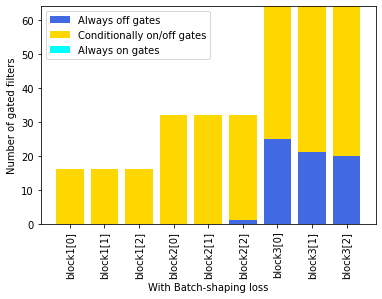

In [92]:
import matplotlib.pyplot as plt
labels = ['block1[0]', 'block1[1]', 'block1[2]',
          'block2[0]', 'block2[1]', 'block2[2]',
          'block3[0]', 'block3[1]', 'block3[2]']

off_list = torch.Tensor(off_list)
on_list = torch.Tensor(on_list)
rest_list = torch.Tensor(rest_list)

fig, ax = plt.subplots()
ax.bar(labels, off_list, color='royalblue', label='Always off gates')
ax.bar(labels, rest_list, bottom=off_list, color='gold', label='Conditionally on/off gates')
ax.bar(labels, on_list, bottom=(rest_list+off_list), color='aqua', label='Always on gates')
plt.xticks(rotation=90)
plt.xlabel('With Batch-shaping loss')
plt.ylabel('Number of gated filters')
plt.legend()


### 6.3 Calculate average FLOPs

In [93]:
def count_gate_open_rate(gate: torch.Tensor):
    # gate.shape[0]: batch size
    # gate.shape[1]: gate numbers (channel numbers)
    batch_size = gate.shape[0]
    gate_num = gate.shape[1]
    print('batch_size = {}, gate_num = {}'.format(batch_size, gate_num))

    count = torch.zeros(gate_num).to(device)
    for i in range(batch_size):
        count = count + gate[i]

        # if i < 2:
        #     print(gate[i])

    print(count)
    open_gates = 0

    for i in range(gate_num):
        open_gates = open_gates + count[i]

    print(open_gates.item())
    avg_open_gates = open_gates / batch_size

    return avg_open_gates

In [94]:
for i in range(3):
    for j in range(3):
        print('block{}[{}].gate'.format(i+1, j))
        print(gates[i][j].shape)
        # print(gates[i][j])
        print(count_gate_open_rate(gates[i][j]).item())


block1[0].gate
torch.Size([5000, 16])
batch_size = 5000, gate_num = 16
tensor([300., 217., 508., 339., 225., 243., 312., 245., 422., 736., 198., 405.,
        194., 251., 240., 165.], device='cuda:1')
5000.0
1.0
block1[1].gate
torch.Size([5000, 16])
batch_size = 5000, gate_num = 16
tensor([428., 470., 216., 189., 219., 307., 445., 278., 159., 159., 196., 646.,
        631., 145., 199., 313.], device='cuda:1')
5000.0
1.0
block1[2].gate
torch.Size([5000, 16])
batch_size = 5000, gate_num = 16
tensor([845., 205., 330., 158., 281., 349., 438., 362., 469., 164., 204., 221.,
        196., 262., 180., 336.], device='cuda:1')
5000.0
1.0
block2[0].gate
torch.Size([5000, 32])
batch_size = 5000, gate_num = 32
tensor([125.,  95., 119., 372., 173.,  72., 123., 118., 459., 123., 212., 159.,
        176.,  87., 121., 110., 233., 210., 144., 208.,  83., 132., 206.,  85.,
        132.,  80., 167., 142., 152., 114., 142., 126.], device='cuda:1')
5000.0
1.0
block2[1].gate
torch.Size([5000, 32])
batch_size

## Step 7: Read Gate Usage for specific classes

In [95]:
# Test on specific pattern

lbl_dict = {'deer': 1, 
            'horse': 2,
            'frog': 3,
            'truck': 4,
            'airplane': 5,
            'cat': 6,
            'dog': 7,
            'ship': 8,
            'bird': 9,
            'automobile': 10}

# print(classes[0].shape)
# print(len(classes))

# print(lbl_dict['truck'])
# print(torch.cat(classes).shape)

### 7.1 Sort gates based on open frequency

The frequency here refers to the number of times a gate is open for the entire
validation set.

In [96]:
# Sort the gate based on execution frequency over the entire validation set

def sort_gate_freq_idx(gate: torch.Tensor):
    # gate.shape[0]: batch size
    # gate.shape[1]: gate numbers (channel numbers)
    batch_size = gate.shape[0]
    gate_num = gate.shape[1]
    # print('batch_size = {}, gate_num = {}'.format(batch_size, gate_num))

    count = torch.zeros(gate_num).to(device)
    for i in range(batch_size):
        count = count + gate[i]

    # print(count)

    return np.argsort(count.detach().cpu().numpy()).tolist()

### 7.2 Plot gate open frequency for a specific class

For different classes, the gate open patterns should also be different.

In [103]:
def get_gate_status_freq(gate: torch.Tensor, targets, cls=0):
    # gate.shape[0]: batch size
    # gate.shape[1]: gate numbers (channel numbers)
    batch_size = gate.shape[0]
    gate_num = gate.shape[1]
    # print('batch_size = {}, gate_num = {}'.format(batch_size, gate_num))

    count = torch.zeros(gate_num).to(device)
    appear_times = 0
    for i in range(batch_size):
        if targets[i] == cls:
            count = count + gate[i]
            appear_times = appear_times + 1

    freq = [None] * gate_num

    for i in range(gate_num):
        freq[i] = count[i].item() / appear_times

    return freq

In [104]:
CLS = lbl_dict['airplane']

sorted_list = []

for i in range(3):
    for j in range(3):
        # print('block{}[{}].gate'.format(i+1, j))
        freq = get_gate_status_freq(gates[i][j], torch.cat(classes), cls=CLS)
        # print(freq)
        sort_idx = sort_gate_freq_idx(gates[i][j])
        # print('sort index = {}'.format(sort_idx))
        sorted_freq = [[freq[i]] for i in sort_idx]
        sorted_freq.reverse()
        sorted_list.append(sorted_freq)

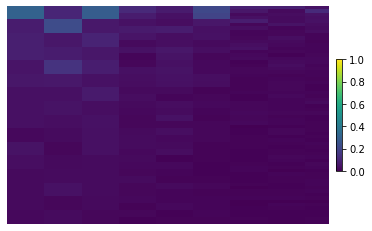

In [105]:
import seaborn as sns

ax = [None] * 9

fig, ax = plt.subplots(ncols=len(ax))
fig.subplots_adjust(wspace=0)
for i in range(len(ax)):
    sns.heatmap(sorted_list[i], cmap='viridis', ax=ax[i], cbar=False, xticklabels=False, yticklabels=False, vmin=0, vmax=1)
fig.colorbar(ax[8].collections[0], ax=ax[8], location='right', use_gridspec=False, pad=0.2)

plt.show()


### 7.3 Plot the gate open frequency for each classes

In [106]:
# Generate heatmap data

plot_2d_list = []

for k in range(len(lbl_dict)):
# for i in range(1):

    sorted_list = []

    for i in range(3):
        for j in range(3):
            # print('block{}[{}].gate'.format(i+1, j))
            freq = get_gate_status_freq(gates[i][j], torch.cat(classes), cls=k)
            # print(freq)
            sort_idx = sort_gate_freq_idx(gates[i][j])
            # print('sort index = {}'.format(sort_idx))
            sorted_freq = [[freq[x]] for x in sort_idx]
            # print(sorted_freq)
            sorted_freq.reverse()
            sorted_list.append(sorted_freq)

    plot_2d_list.append(sorted_list)


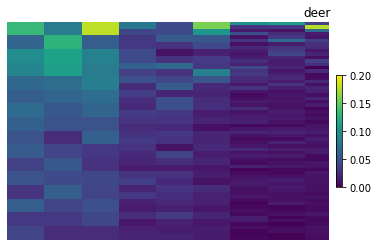

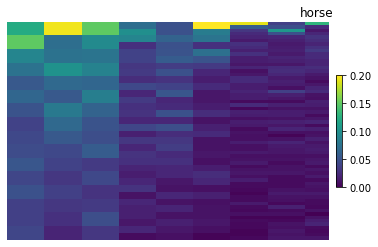

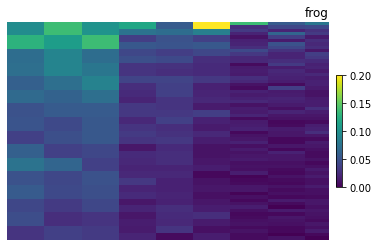

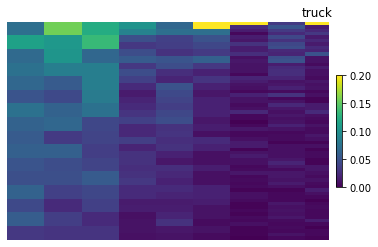

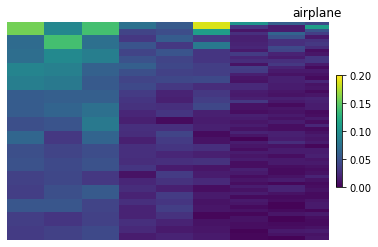

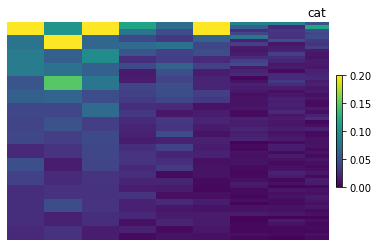

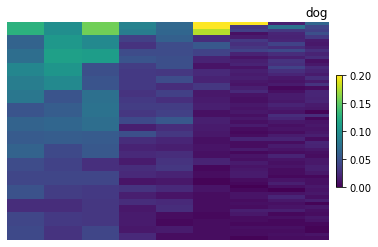

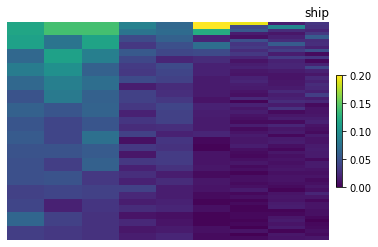

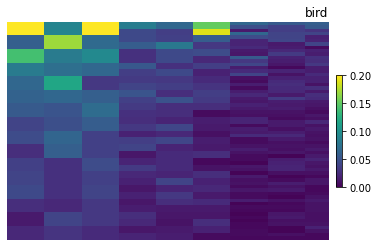

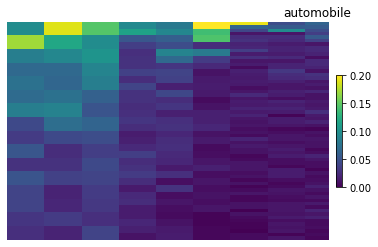

In [107]:
# Plot heatmaps

for i in range(len(lbl_dict)):
# for i in range(1):

    ax = [None] * 9

    fig, ax = plt.subplots(ncols=len(ax))
    fig.subplots_adjust(wspace=0)
    for j in range(len(ax)):
        sns.heatmap(plot_2d_list[i][j], cmap='viridis', ax=ax[j], cbar=False, xticklabels=False, yticklabels=False, vmin=0, vmax=0.2)
    fig.colorbar(ax[8].collections[0], ax=ax[8], location='right', use_gridspec=False, pad=0.2)

    plt.title(list(lbl_dict.keys())[list(lbl_dict.values()).index(i+1)])

    plt.show()

### 7.4 Plot the heatmap of difference between classes

In [108]:
# print(len(plot_2d_list))
# print(len(plot_2d_list[0]))
# print(len(plot_2d_list[0][0]))
# print(len(plot_2d_list[0][0][0]))

For similar classses, the gate pattern should also be similar.

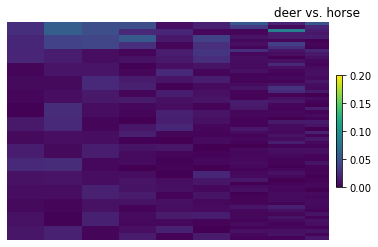

In [109]:
cls_1 = 'deer'
cls_2 = 'horse'

org_1 = plot_2d_list[lbl_dict[cls_1]]
org_2 = plot_2d_list[lbl_dict[cls_2]]
diff = []

for i in range(len(org_1)):
    diff_l1 = []
    for j in range(len(org_1[i])):
        diff_l2 = []
        for k in range(len(org_1[i][j])):
            # print(abs(org_1[i][j][k] - org_2[i][j][k]))
            # diff[i][j][k] = abs(org_1[i][j][k] - org_2[i][j][k])
            diff_l2.append(abs(org_1[i][j][k] - org_2[i][j][k]))
        diff_l1.append(diff_l2)
    diff.append(diff_l1)

ax = [None] * 9

fig, ax = plt.subplots(ncols=len(ax))
fig.subplots_adjust(wspace=0)
for m in range(len(ax)):
    sns.heatmap(diff[m], cmap='viridis', ax=ax[m], cbar=False, xticklabels=False, yticklabels=False, vmin=0, vmax=0.2)
fig.colorbar(ax[8].collections[0], ax=ax[8], location='right', use_gridspec=False, pad=0.2)

plt.title(cls_1 + ' vs. ' + cls_2)

plt.show()

For not that similar classses, the gate pattern should be less similar.

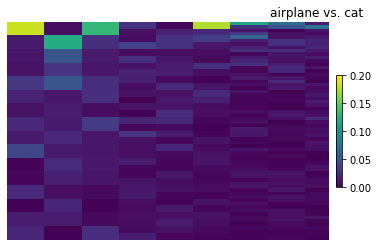

In [110]:
cls_1 = 'airplane'
cls_2 = 'cat'

org_1 = plot_2d_list[lbl_dict[cls_1]]
org_2 = plot_2d_list[lbl_dict[cls_2]]
diff = []

for i in range(len(org_1)):
    diff_l1 = []
    for j in range(len(org_1[i])):
        diff_l2 = []
        for k in range(len(org_1[i][j])):
            # print(abs(org_1[i][j][k] - org_2[i][j][k]))
            # diff[i][j][k] = abs(org_1[i][j][k] - org_2[i][j][k])
            diff_l2.append(abs(org_1[i][j][k] - org_2[i][j][k]))
        diff_l1.append(diff_l2)
    diff.append(diff_l1)

ax = [None] * 9

fig, ax = plt.subplots(ncols=len(ax))
fig.subplots_adjust(wspace=0)
for m in range(len(ax)):
    sns.heatmap(diff[m], cmap='viridis', ax=ax[m], cbar=False, xticklabels=False, yticklabels=False, vmin=0, vmax=0.2)
fig.colorbar(ax[8].collections[0], ax=ax[8], location='right', use_gridspec=False, pad=0.2)

plt.title(cls_1 + ' vs. ' + cls_2)

plt.show()